In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest



In [5]:
df = pd.read_csv('df_alldata.csv')

In [6]:
df

,client_id,variation,tenure_year,tenure_month,age,gender,accounts,balance,calls_semester,logons_semester,balance_thousands,visitor_id,visit_id,process_step,date_time
0,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,189.02,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251614,6334360,Test,4.0,53.0,66.5,U,2.0,93103.47,6.0,9.0,93.10,629124187_65258232847,586047816_14599436811_389185,step_2,2017-04-11 08:45:38
251615,6334360,Test,4.0,53.0,66.5,U,2.0,93103.47,6.0,9.0,93.10,629124187_65258232847,586047816_14599436811_389185,step_1,2017-04-11 08:44:43
251616,6334360,Test,4.0,53.0,66.5,U,2.0,93103.47,6.0,9.0,93.10,629124187_65258232847,586047816_14599436811_389185,step_2,2017-04-11 08:44:30
251617,6334360,Test,4.0,53.0,66.5,U,2.0,93103.47,6.0,9.0,93.10,629124187_65258232847,586047816_14599436811_389185,step_1,2017-04-11 08:42:36


In [7]:
# Dataframe with funnel errors 

# Convert the 'date_time' column to datetime type
df['date_time'] = pd.to_datetime(df['date_time'])

# Sort the data by 'client_id', 'visitor_id', 'visit_id', and 'date_time' in ascending order
df_sorted = df.sort_values(by=['client_id', 'visitor_id', 'visit_id', 'date_time'], ascending=[True, True, True, True])

# Define the expected process_step order
expected_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Initialize the "errors" column
df_sorted['errors'] = ''

# Group the data by visit_id to evaluate each session
def evaluate_funnel(group):
    process_steps = group['process_step'].tolist()

    # Case 1: Visit_id has exactly the 5 steps in the correct order
    if process_steps == expected_steps:
        group['errors'] = 'correct_funnel_order_complete'
    
    # Case 2: Visit_id has all 5 steps but in the wrong order or with extra steps
    elif all(step in process_steps for step in expected_steps) and process_steps[-1] == 'confirm':
        group['errors'] = 'incorrect_funnel_order_complete'
    
    # Case 3: Visit_id does not have all 5 distinct steps
    else:
        group['errors'] = 'funnel_error'

    return group

# Apply the function to each visit_id group
df_with_errors = df_sorted.groupby('visit_id').apply(evaluate_funnel)


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_12852/3822145233.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_errors = df_sorted.groupby('visit_id').apply(evaluate_funnel)


In [8]:
df_with_errors.to_csv("df_with_errors.csv")

In [9]:
# Dataframe with success column

In [10]:
# Create the new column 'funnel_success' based on the 'errors' column
df_with_errors['funnel_success'] = df_with_errors['errors'].apply(lambda x: 0 if x == 'funnel_error' else 1)

In [11]:
df = df_with_errors
df.to_csv("df_with_success.csv")

In [12]:
# Group by 'client_id', then for each 'client_id', get the unique 'visit_id' and calculate the % of successful funnels
success_percentage = df.groupby('client_id').apply(lambda group: pd.Series({
    'unique_visit_ids': group['visit_id'].nunique(),
    'success_percentage': group['funnel_success'].mean() * 100
})).reset_index()


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_12852/2037172356.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_percentage = df.groupby('client_id').apply(lambda group: pd.Series({


In [26]:
success_percentage

,client_id,unique_visit_ids,success_percentage
0,555,1.0,100.0
1,647,1.0,100.0
2,934,1.0,0.0
3,1028,1.0,0.0
4,1186,2.0,0.0
...,...,...,...
40012,9998921,1.0,0.0
40013,9998964,2.0,0.0
40014,9999009,1.0,100.0
40015,9999400,1.0,100.0


In [13]:
# Calculate the average number of visits per client_id
average_visits_per_client = success_percentage['unique_visit_ids'].mean()

# Calculate the overall average success rate (amount of success funnel / amount of visit_id)
average_success_rate = df.groupby('client_id')['funnel_success'].mean().mean() * 100

average_visits_per_client, average_success_rate


(1.3038208761276457, 56.76317223405627)

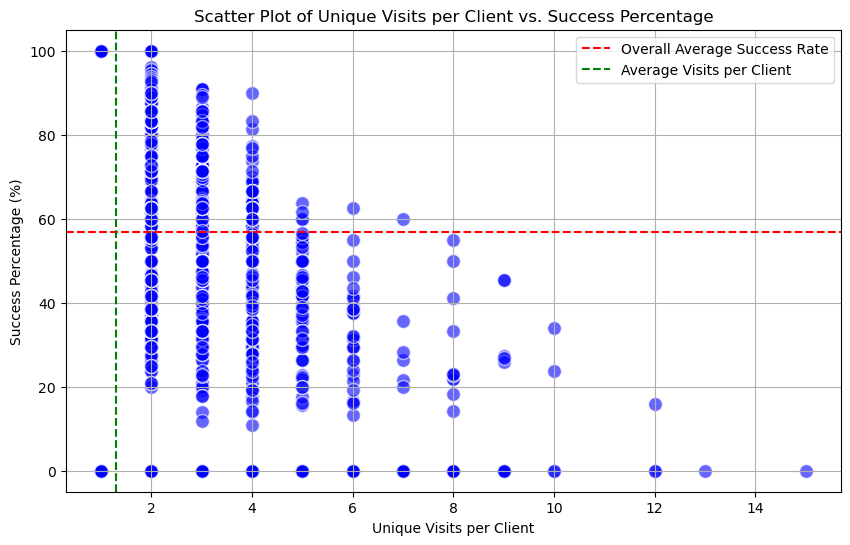

In [27]:
# Scatter plot of the average visits per client against the success rate for each client
plt.figure(figsize=(10, 6))
plt.scatter(success_percentage['unique_visit_ids'], success_percentage['success_percentage'], color='blue', s=100, alpha=0.6, edgecolors='w')
plt.axhline(average_success_rate, color='r', linestyle='--', label='Overall Average Success Rate')
plt.axvline(average_visits_per_client, color='g', linestyle='--', label='Average Visits per Client')
plt.title('Scatter Plot of Unique Visits per Client vs. Success Percentage')
plt.xlabel('Unique Visits per Client')
plt.ylabel('Success Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Grouping the data by 'client_id' and 'variation' to perform comparison between Test and Control groups
comparison = df.groupby(['variation', 'client_id']).apply(lambda group: pd.Series({
    'unique_visit_ids': group['visit_id'].nunique(),
    'success_percentage': group['funnel_success'].mean() * 100
})).reset_index()

# Calculate the average number of visits per client_id and success rate for Test and Control groups
comparison_summary = comparison.groupby('variation').agg({
    'unique_visit_ids': 'mean',
    'success_percentage': 'mean'
}).reset_index()


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_12852/3112683169.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comparison = df.groupby(['variation', 'client_id']).apply(lambda group: pd.Series({


In [15]:
comparison_summary

,variation,unique_visit_ids,success_percentage
0,Control,1.296985,53.714009
1,Test,1.309416,59.258786


In [16]:
# Remove unnecessary columns and keep the relevant ones
df_clean = df[['visit_id', 'client_id', 'variation', 'funnel_success']]

# Group by client_id to calculate the total visits and average success rate for each client
client_visits = df_clean.groupby('client_id').agg(
    total_visits=('visit_id', 'nunique'), 
    avg_success_rate=('funnel_success', 'mean')
).reset_index()

# Overall analysis
overall_total_visits = client_visits['total_visits'].sum()
overall_avg_success_rate = client_visits['avg_success_rate'].mean()

# Comparative analysis by test vs control groups
variation_grouped = df_clean.groupby(['variation', 'client_id']).agg(
    total_visits=('visit_id', 'nunique'),
    avg_success_rate=('funnel_success', 'mean')
).reset_index()

test_group = variation_grouped[variation_grouped['variation'] == 'Test']
control_group = variation_grouped[variation_grouped['variation'] == 'Control']

test_avg_visits = test_group['total_visits'].mean()
test_avg_success_rate = test_group['avg_success_rate'].mean()

control_avg_visits = control_group['total_visits'].mean()
control_avg_success_rate = control_group['avg_success_rate'].mean()

# Display overall and comparative results
overall_results = {
    'Overall Total Visits': overall_total_visits,
    'Overall Average Success Rate': overall_avg_success_rate,
    'Test Group Average Visits': test_avg_visits,
    'Test Group Average Success Rate': test_avg_success_rate,
    'Control Group Average Visits': control_avg_visits,
    'Control Group Average Success Rate': control_avg_success_rate
}

overall_results


{'Overall Total Visits': 52175,
 'Overall Average Success Rate': 0.5676317223405627,
 'Test Group Average Visits': 1.3094156139234754,
 'Test Group Average Success Rate': 0.5925878625850841,
 'Control Group Average Visits': 1.2969851757259452,
 'Control Group Average Success Rate': 0.5371400882158088}

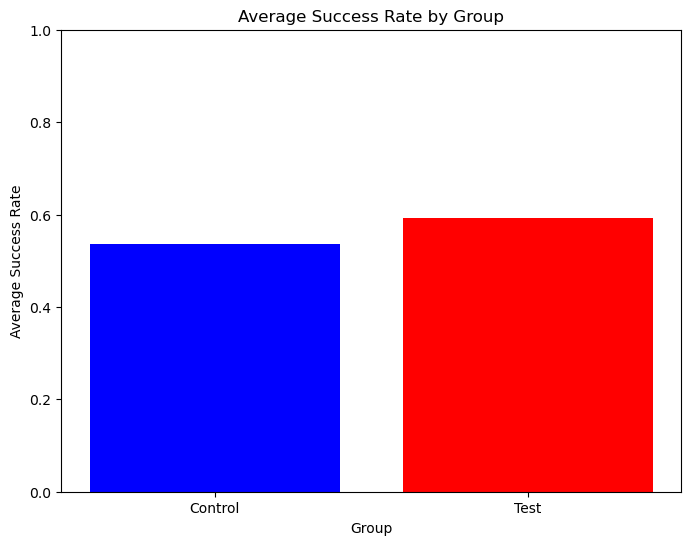

In [17]:
# Plot the success rates by group
groups = ['Control', 'Test']
success_rates = [control_avg_success_rate, test_avg_success_rate]

plt.figure(figsize=(8, 6))
plt.bar(groups, success_rates, color=['blue', 'red'])
plt.xlabel('Group')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Group')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 to represent percentages

# Display the plot
plt.show()


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_12852/767436914.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_new = df.groupby('age_group_new').agg(


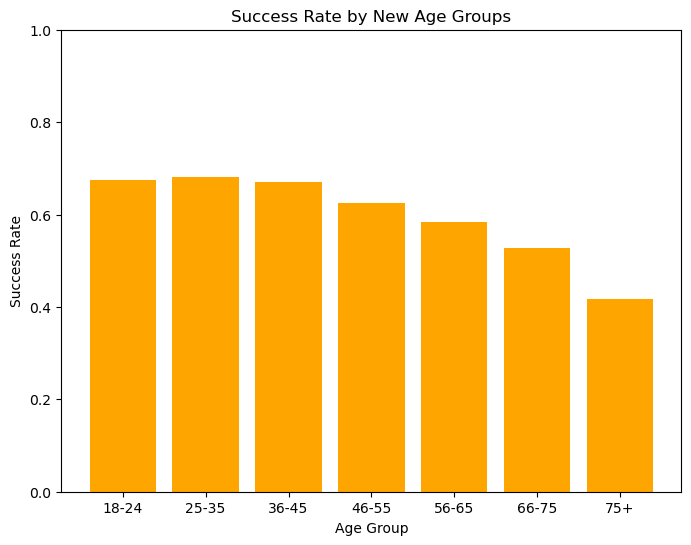

In [18]:
# Modify the age bins and labels as per the new ranges
age_bins_new = [18, 24, 35, 45, 55, 65, 75, 100]
age_labels_new = ['18-24', '25-35', '36-45', '46-55', '56-65', '66-75', '75+']
df['age_group_new'] = pd.cut(df['age'], bins=age_bins_new, labels=age_labels_new)

# Group by the new age groups to calculate the success rate for each group
success_rate_by_age_new = df.groupby('age_group_new').agg(
    total_visits=('visit_id', 'nunique'),
    success_rate=('funnel_success', 'mean')
).reset_index()

# Plot the success rate by the new age group
plt.figure(figsize=(8, 6))
plt.bar(success_rate_by_age_new['age_group_new'], success_rate_by_age_new['success_rate'], color='orange')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.title('Success Rate by New Age Groups')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 to represent percentages

# Display the plot
plt.show()


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_12852/160973106.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_group_variation = df.groupby(['age_group_new', 'variation']).agg(


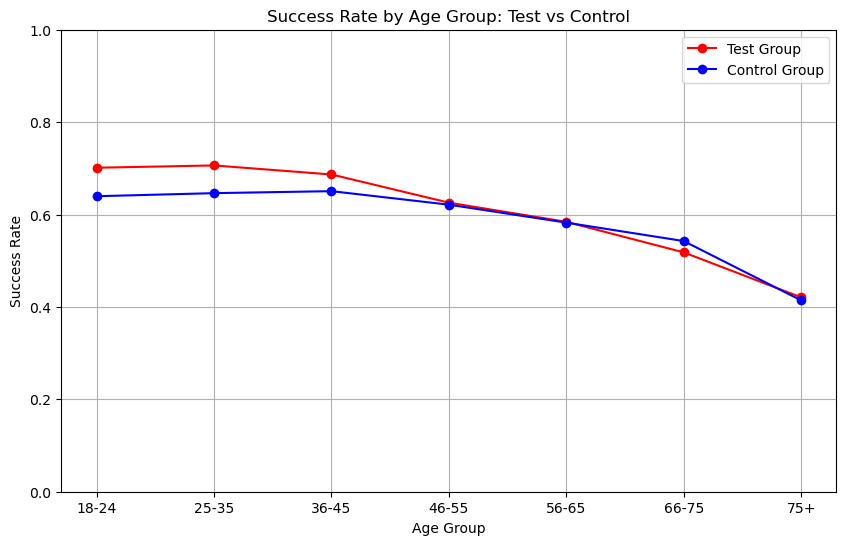

In [28]:
# Group by age group and variation to calculate success rate for Test and Control groups
success_rate_by_age_group_variation = df.groupby(['age_group_new', 'variation']).agg(
    total_visits=('visit_id', 'nunique'),
    success_rate=('funnel_success', 'mean')
).reset_index()

# Separate data for Test and Control groups
test_data = success_rate_by_age_group_variation[success_rate_by_age_group_variation['variation'] == 'Test']
control_data = success_rate_by_age_group_variation[success_rate_by_age_group_variation['variation'] == 'Control']

# Plot the success rates by age group for Test and Control
plt.figure(figsize=(10, 6))
plt.plot(test_data['age_group_new'], test_data['success_rate'], marker='o', label='Test Group', color='red')
plt.plot(control_data['age_group_new'], control_data['success_rate'], marker='o', label='Control Group', color='blue')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.title('Success Rate by Age Group: Test vs Control')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 to represent percentages
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

#add statistical significant


In [20]:

# Calculate success rate based on unique successful visits (1 success max per visit)
df_unique_visits = df_clean.drop_duplicates(subset=['visit_id'])

# Group by variation to calculate the number of visits and the rate of successful visits
visits_and_success_unique = df_unique_visits.groupby('variation').agg(
    total_visits=('visit_id', 'nunique'),
    successful_visits=('funnel_success', 'sum')
).reset_index()

# Calculate success rate (successful visits / total visits)
visits_and_success_unique['success_rate'] = visits_and_success_unique['successful_visits'] / visits_and_success_unique['total_visits']

# Display the updated success rate
visits_and_success_unique



,variation,total_visits,successful_visits,success_rate
0,Control,23273,10264,0.441026
1,Test,28709,14017,0.488244


In [21]:
from scipy import stats
import numpy as np

# Prepare data for two-sample t-test
control_success_rates = df_unique_visits[df_unique_visits['variation'] == 'Control']['funnel_success']
test_success_rates = df_unique_visits[df_unique_visits['variation'] == 'Test']['funnel_success']

# Perform two-sample t-test
t_stat, p_value_ttest = stats.ttest_ind(control_success_rates, test_success_rates)

# Prepare data for chi-square test (success vs failure for control and test groups)
control_successes = control_success_rates.sum()
control_failures = len(control_success_rates) - control_successes
test_successes = test_success_rates.sum()
test_failures = len(test_success_rates) - test_successes

# Create a contingency table
contingency_table = np.array([[control_successes, control_failures], [test_successes, test_failures]])

# Perform chi-square test
chi2_stat, p_value_chi2, _, _ = stats.chi2_contingency(contingency_table)

# Output the results of both tests
t_test_results = {
    't_statistic': t_stat,
    'p_value_ttest': p_value_ttest
}

chi2_test_results = {
    'chi2_statistic': chi2_stat,
    'p_value_chi2': p_value_chi2
}

t_test_results, chi2_test_results

#repeat the significant between success and success & failure and failure


({'t_statistic': -10.741417690133224, 'p_value_ttest': 6.940818820769825e-27},
 {'chi2_statistic': 114.9373352939181, 'p_value_chi2': 8.12240401629767e-27})

In [29]:
# Create a contingency table
contingency_table_2 = np.array([[control_successes,test_successes], [control_failures, test_failures]])

# Perform chi-square test
chi2_stat, p_value_chi2, _, _ = stats.chi2_contingency(contingency_table_2)

# Output the results of both tests
t_test_results = {
    't_statistic': t_stat,
    'p_value_ttest': p_value_ttest
}

chi2_test_results = {
    'chi2_statistic': chi2_stat,
    'p_value_chi2': p_value_chi2
}

t_test_results, chi2_test_results

#repeat the significant between success and success & failure and failure


({'t_statistic': -10.741417690133224, 'p_value_ttest': 6.940818820769825e-27},
 {'chi2_statistic': 114.9373352939181, 'p_value_chi2': 8.12240401629767e-27})

In [22]:
# Calculate the difference in success rates
success_rate_difference = test_avg_success_rate - control_avg_success_rate

# Determine if the A/B test is successful based on the 5% criterion
is_successful = success_rate_difference >= 0.05

# Create a summary of the results
results_summary = {
    'Test Group Success Rate (%)': round(test_avg_success_rate * 100, 2),
    'Control Group Success Rate (%)': round(control_avg_success_rate * 100, 2),
    'Success Rate Difference (%)': round(success_rate_difference * 100, 2),
    'Is A/B Test Successful (5% criterion)': is_successful,
    't-test p-value': p_value_ttest,
    'Chi-square p-value': p_value_chi2
}

results_summary


{'Test Group Success Rate (%)': 59.26,
 'Control Group Success Rate (%)': 53.71,
 'Success Rate Difference (%)': 5.54,
 'Is A/B Test Successful (5% criterion)': True,
 't-test p-value': 6.940818820769825e-27,
 'Chi-square p-value': 8.12240401629767e-27}

In [30]:
success_rate_percentage_difference = ((test_avg_success_rate - control_avg_success_rate) / control_avg_success_rate) * 100
success_rate_percentage_difference

10.32277716479017

In [23]:
# Deduplicate the data by unique visit_id and client_id, keeping only one success or failure per unique visit
df_dedup = df_clean.drop_duplicates(subset=['visit_id', 'client_id'])

# Group by client_id and variation to calculate unique visits and success rate, ensuring only one success or failure per visit
client_visit_success_updated = df_dedup.groupby(['client_id', 'variation']).agg(
    unique_visits=('visit_id', 'nunique'),
    total_successes=('funnel_success', 'sum')
).reset_index()

# Calculate the success rate per client (based on one success or failure per unique visit)
client_visit_success_updated['success_rate'] = client_visit_success_updated['total_successes'] / client_visit_success_updated['unique_visits']

# Separate data for Test and Control groups
client_visit_success_updated_test = client_visit_success_updated[client_visit_success_updated['variation'] == 'Test']
client_visit_success_updated_control = client_visit_success_updated[client_visit_success_updated['variation'] == 'Control']

# Display the first few rows of the updated analysis for both groups
client_visit_success_updated_test.head(), client_visit_success_updated_control.head()




(   client_id variation  unique_visits  total_successes  success_rate
 0        555      Test              1                1           1.0
 1        647      Test              1                1           1.0
 2        934      Test              1                0           0.0
 8       1516      Test              2                1           0.5
 9       1643      Test              2                0           0.0,
    client_id variation  unique_visits  total_successes  success_rate
 3       1028   Control              1                0           0.0
 4       1186   Control              2                0           0.0
 5       1195   Control              1                1           1.0
 6       1197   Control              1                1           1.0
 7       1368   Control              1                0           0.0)

In [24]:
# Calculate the average success rate across all clients for Test and Control groups
avg_success_rate_test = client_visit_success_updated_test['success_rate'].mean()
avg_success_rate_control = client_visit_success_updated_control['success_rate'].mean()

# Summarize the average success rates
success_rate_summary = {
    'Average Success Rate - Test Group (%)': round(avg_success_rate_test * 100, 2),
    'Average Success Rate - Control Group (%)': round(avg_success_rate_control * 100, 2)
}

success_rate_summary


{'Average Success Rate - Test Group (%)': 56.05,
 'Average Success Rate - Control Group (%)': 50.93}

In [35]:
df_sorted

,client_id,variation,tenure_year,tenure_month,age,gender,accounts,balance,calls_semester,logons_semester,balance_thousands,visitor_id,visit_id,process_step,date_time,errors
73801,555,Test,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,25.45,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,
73800,555,Test,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,25.45,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,
73799,555,Test,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,25.45,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,
73798,555,Test,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,25.45,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,
73797,555,Test,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,25.45,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109816,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,6.0,9.0,107.06,843385170_36953471821,493310979_9209676464_421146,start,2017-04-20 14:21:27,
109815,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,6.0,9.0,107.06,843385170_36953471821,493310979_9209676464_421146,step_1,2017-04-20 14:22:49,
109814,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,6.0,9.0,107.06,843385170_36953471821,493310979_9209676464_421146,step_2,2017-04-20 14:27:36,
109813,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,6.0,9.0,107.06,843385170_36953471821,493310979_9209676464_421146,start,2017-04-20 14:28:57,


In [36]:
# Step 1: Convert 'date_time' to datetime format
df_sorted['date_time'] = pd.to_datetime(df_sorted['date_time'], errors='coerce')

# Step 2: Sort by client_id, visit_id, and date_time to ensure proper sequence
df_sorted = df_sorted.sort_values(by=['client_id', 'visit_id', 'date_time'], ignore_index=True)

# Step 3: Calculate 'time_spent' as the difference between consecutive steps within the same client and visit
df_sorted['next_date_time'] = df_sorted.groupby(['client_id', 'visit_id'])['date_time'].shift(-1)
df_sorted['time_spent'] = (df_sorted['next_date_time'] - df_sorted['date_time']).dt.total_seconds()

# Step 4: Remove rows where 'time_spent' is NaN, which indicates the last step in each sequence
df_steps_duration_corrected = df_sorted.dropna(subset=['time_spent'])

# Step 5: Remove the 'confirm' step, as it's the final step and shouldn't have a following step
df_steps_duration_corrected = df_steps_duration_corrected[df_steps_duration_corrected['process_step'] != 'confirm']

# Step 6: Recalculate the average time spent per step, grouped by 'variation' and 'process_step'
avg_step_duration_corrected = df_steps_duration_corrected.groupby(['variation', 'process_step'])['time_spent'].mean().reset_index()
avg_step_duration_corrected.rename(columns={'time_spent': 'avg_time_spent_seconds'}, inplace=True)

# Display the final corrected results
print(avg_step_duration_corrected)

  variation process_step  avg_time_spent_seconds
0   Control        start               68.900262
1   Control       step_1               47.337968
2   Control       step_2               92.559155
3   Control       step_3              143.655161
4      Test        start               60.200626
5      Test       step_1               62.049775
6      Test       step_2               88.366531
7      Test       step_3              131.994556


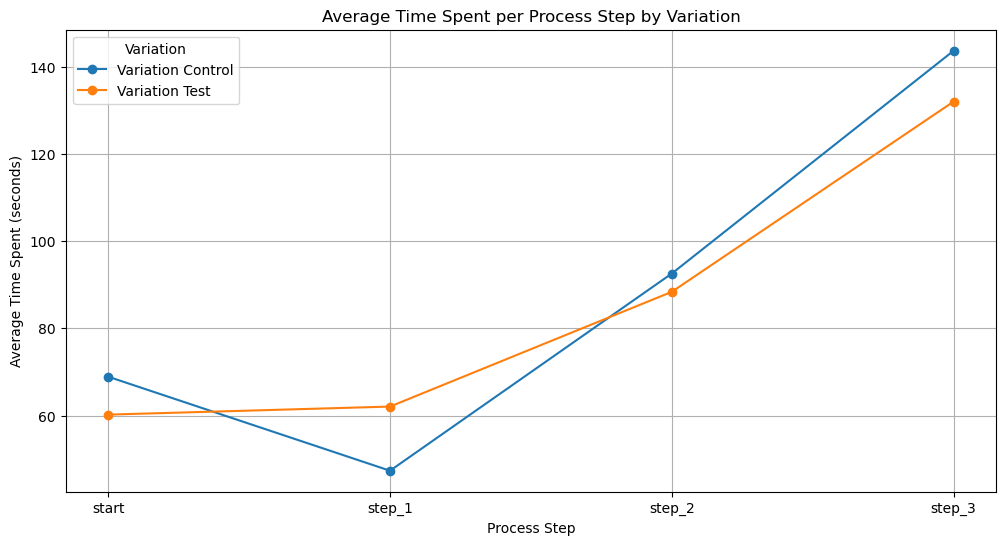

In [37]:
plt.figure(figsize=(12, 6))
for variation in avg_step_duration_corrected['variation'].unique():
    subset = avg_step_duration_corrected[avg_step_duration_corrected['variation'] == variation]
    plt.plot(subset['process_step'], subset['avg_time_spent_seconds'], marker='o', label=f'Variation {variation}')

plt.title('Average Time Spent per Process Step by Variation')
plt.xlabel('Process Step')
plt.ylabel('Average Time Spent (seconds)')
plt.legend(title='Variation')
plt.grid(True)
plt.show()

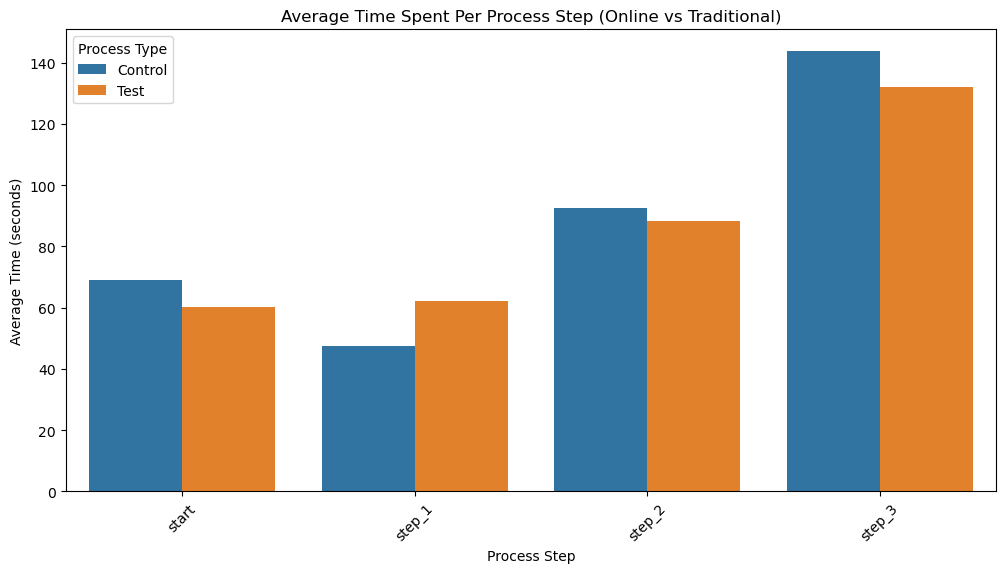

In [38]:

# Define the order for the process steps
order = ["start", "step_1", "step_2", "step_3"]

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar plot with the specified order
sns.barplot(
    data=avg_step_duration_corrected,
    x='process_step',
    y='avg_time_spent_seconds',
    hue='variation',
    order=order
)

# Customize the plot
plt.title("Average Time Spent Per Process Step (Online vs Traditional)")
plt.xlabel("Process Step")
plt.ylabel("Average Time (seconds)")
plt.legend(title="Process Type")
plt.xticks(rotation=45)

# Show the plot
plt.show()

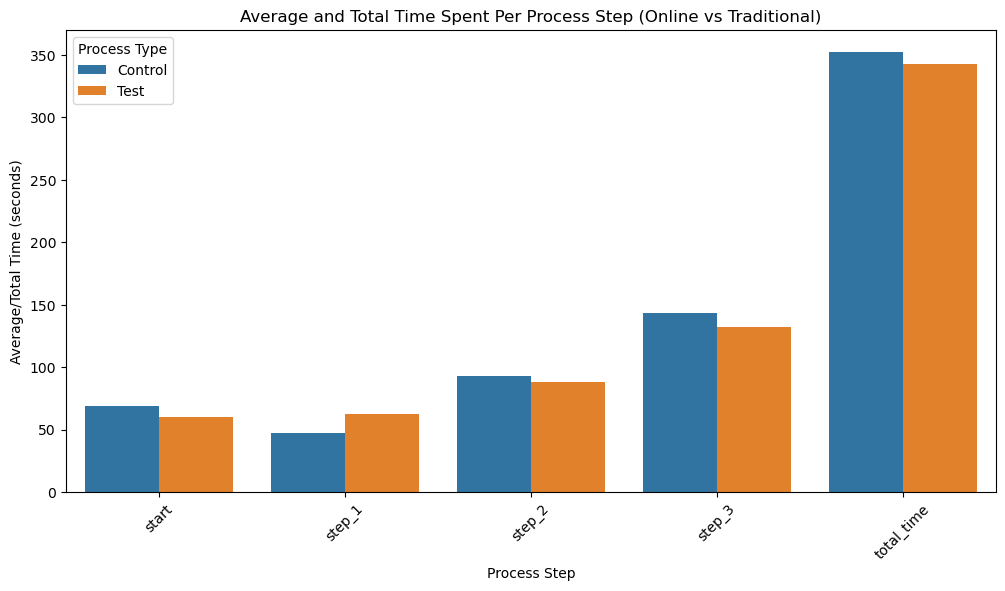

In [39]:
# Step 1: Calculate the cumulative time spent for each variation
total_time_spent = avg_step_duration_corrected.groupby('variation')['avg_time_spent_seconds'].sum().reset_index()
total_time_spent['process_step'] = 'total_time'

# Step 2: Append the total time to the original dataset
avg_step_duration_with_total = pd.concat([avg_step_duration_corrected, total_time_spent], ignore_index=True)

# Step 3: Define the order for the process steps, including the total time
order = ["start", "step_1", "step_2", "step_3", "total_time"]

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar plot with the specified order
sns.barplot(
    data=avg_step_duration_with_total,
    x='process_step',
    y='avg_time_spent_seconds',
    hue='variation',
    order=order
)

# Customize the plot
plt.title("Average and Total Time Spent Per Process Step (Online vs Traditional)")
plt.xlabel("Process Step")
plt.ylabel("Average/Total Time (seconds)")
plt.legend(title="Process Type")
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [40]:
# Step 1: Calculate the total unique clients for each variation
total_clients = df_sorted.groupby('variation')['client_id'].nunique().reset_index()
total_clients.rename(columns={'client_id': 'total_clients'}, inplace=True)

# Step 2: Count unique clients reaching each step, grouped by variation and process step
clients_per_step = df_sorted.groupby(['variation', 'process_step'])['client_id'].nunique().reset_index()
clients_per_step.rename(columns={'client_id': 'clients_per_step'}, inplace=True)

# Step 3: Merge with the total clients to calculate the percentage reaching each step
clients_per_step = clients_per_step.merge(total_clients, on='variation')
clients_per_step['percentage_reaching_step'] = (clients_per_step['clients_per_step'] / clients_per_step['total_clients']) * 100

# Display the results
print(clients_per_step[['variation', 'process_step', 'percentage_reaching_step']])

  variation process_step  percentage_reaching_step
0   Control      confirm                 48.295503
1   Control        start                 76.273060
2   Control       step_1                 64.163054
3   Control       step_2                 59.589390
4   Control       step_3                 55.389782
5      Test      confirm                 55.740198
6      Test        start                 80.726288
7      Test       step_1                 73.389221
8      Test       step_2                 67.220594
9      Test       step_3                 62.902927


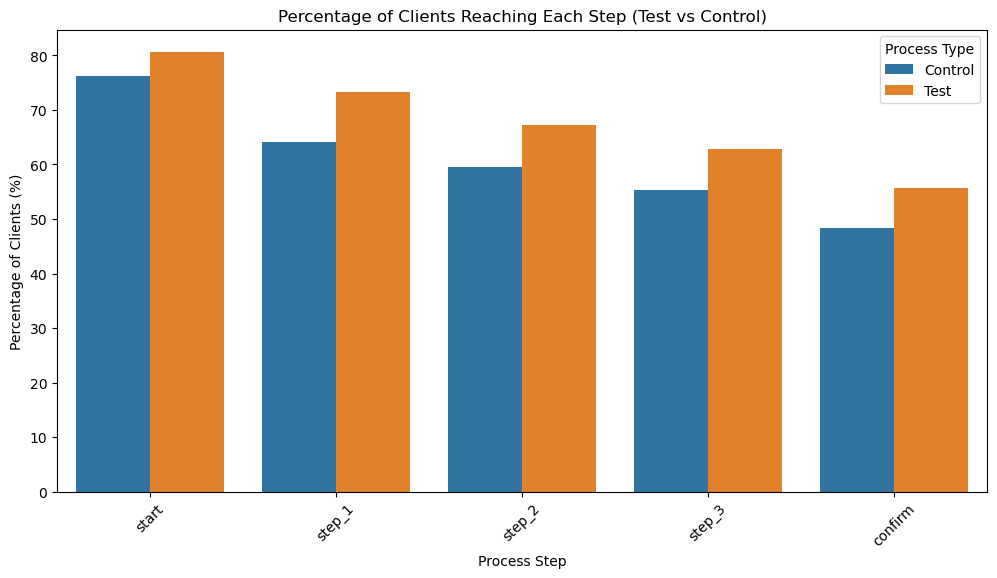

In [41]:
# Define the order for the process steps
order = ["start", "step_1", "step_2", "step_3", "confirm"]

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar plot with the specified order
sns.barplot(
    data=clients_per_step,
    x='process_step',
    y='percentage_reaching_step',
    hue='variation',
    order=order
)

# Customize the plot
plt.title("Percentage of Clients Reaching Each Step (Test vs Control)")
plt.xlabel("Process Step")
plt.ylabel("Percentage of Clients (%)")
plt.legend(title="Process Type")
plt.xticks(rotation=45)

# Show the plot
plt.show()

<Axes: xlabel='process_step', ylabel='percentage_reaching_step'>

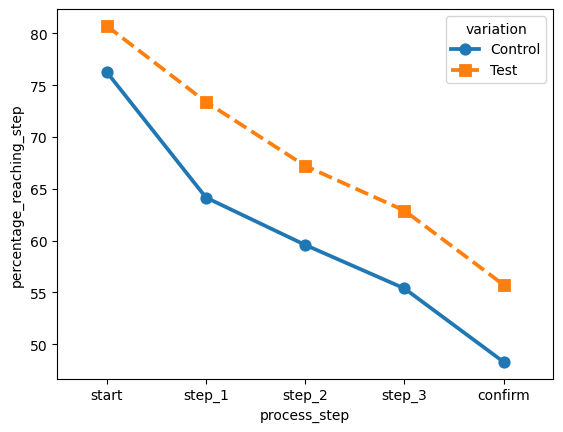

In [43]:
sns.pointplot(
    data=clients_per_step,
    x='process_step',
    y='percentage_reaching_step',
    hue='variation',
    order=order,
    markers=['o', 's'],  # Different markers for each variation
    linestyles=['-', '--'])  # Different line styles for variation